### Dataset
- [Litho1.0](https://github.com/underworldcode/litho1pt0) (Global model of lithospheric properties that builds upon Crust 1.0)

### Reference
- Pasyanos, M. E., Masters, T. G., Laske, G., & Ma, Z. (2014). LITHO1. 0: An updated crust and lithospheric model of the Earth. Journal of Geophysical Research: Solid Earth, 119(3), 2153-2173.

In [1]:
import litho1pt0 as litho
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# parameters for cartopy
rivers    = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '110m',edgecolor=(0.0,0.0,0.0),facecolor="none")
prj_base  = ccrs.PlateCarree()

# parameters for plot
xticks_global = np.arange(-180,180+10,60)
yticks_global = np.arange(-90,90+10,30)
xticks_area = np.arange(-180,180+5,5)
yticks_area = np.arange(-90,90+5,5)
dpi = 150

outputfile = "output_1_01_03/"
outputPath = os.path.join(os.path.abspath("."),outputfile) 
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

In [3]:
import stripy

def great_circle_profile(startlonlat, endlonlat, depths, resolution, QID):
    """
    model: self
    ll0: (lon0, lat0)
    ll1: (lon1, lat1)
    depths (km)
    resolution: separation (km) of locations to sample along the profile
    """
   
    import stripy

    lons, lats = great_circle_Npoints(startlonlat, endlonlat, 1000)
    
    ## Would be useful to have distance measure here to map resolutions ... 
    
    data = np.empty( (lons.shape[0], depths.shape[0]))
    
    for s, ll in enumerate(lons):
        c, profile = litho.property_on_depth_profile(np.degrees(lats[s]), np.degrees(lons[s]), depths, QID)   
        data[s,:] = profile[:]
      
    return np.degrees(lons), np.degrees(lats), data
      
    
def great_circle_Npoints(lonlat1, lonlat2, N):
    """
    N points along the line joining lonlat1 and lonlat2
    """ 

    ratio = np.linspace(0.0,1.0, N).reshape(-1,1)
    
    lonlat1r = np.radians(lonlat1)
    lonlat2r = np.radians(lonlat2)
    
    xyz1 = stripy.spherical.lonlat2xyz(lonlat1r[0], lonlat1r[1])
    xyz2 = stripy.spherical.lonlat2xyz(lonlat2r[0], lonlat2r[1])
    
    xyz1 = np.array(xyz1)
    xyz2 = np.array(xyz2) 
    
    mids = ratio * xyz2.T + (1.0-ratio) * xyz1.T
    norm = (mids**2).sum(axis=1)
    xyzN = mids / norm.reshape(-1,1)
    
    lonlatN = stripy.spherical.xyz2lonlat( xyzN[:,0], xyzN[:,1], xyzN[:,2])
    
    return lonlatN

In [5]:
depths = np.linspace(-10.0, 250, 100)
startlonlat = np.array([94.0,30.0])
endlonlat   = np.array([106.0,30.0])


minlon,maxlon = startlonlat[0],endlonlat[0]
minlat,maxlat = startlonlat[1],endlonlat[1]
midlonlat  = 0.5 * (startlonlat+endlonlat)
mindepth,maxdepth = depths[0],depths[-1]

lons, lats, d = great_circle_profile(startlonlat, endlonlat, depths, 2.5, "DENSITY")
lonr, latr = great_circle_Npoints(startlonlat, endlonlat, 10)
ptslo  = np.degrees(lonr)
ptsla  = np.degrees(latr)

lab = -litho.layer_depth(lat=lats, lon=lons, layerID="LID-BOTTOM")*0.001
moho = -litho.layer_depth(lat=lats, lon=lons, layerID="CRUST3-BOTTOM")*0.001
upperc_bot = -litho.layer_depth(lat=lats, lon=lons, layerID="CRUST1-BOTTOM")*0.001
midc_bot = -litho.layer_depth(lat=lats, lon=lons, layerID="CRUST2-BOTTOM")*0.001
topo = -litho.layer_depth(lat=lats, lon=lons, layerID="WATER-BOTTOM")*0.001

/home/nl/anaconda3/envs/py37/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


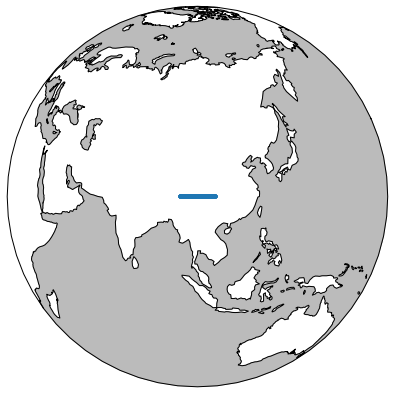

In [6]:
fig = plt.figure(figsize=(7, 7), facecolor="none")

ax  = plt.subplot(111, projection=ccrs.Orthographic(central_latitude=midlonlat[1], central_longitude=midlonlat[0]))
ax.set_global()
ax.add_feature(cartopy.feature.OCEAN, alpha=1.0, facecolor="#BBBBBB", zorder=0)
ax.scatter(lons, lats, s=10,transform=ccrs.Geodetic(), zorder=100)
ax.coastlines()

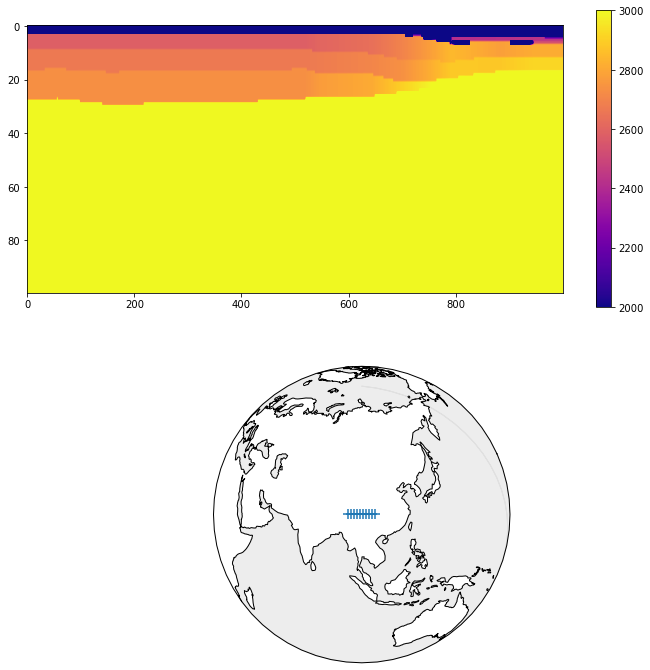

In [7]:
# Cross section
fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.subplot(211)
ax2 = plt.subplot(212, projection=ccrs.Orthographic(central_latitude=midlonlat[1], 
                                                    central_longitude=midlonlat[0]))

image = d[:,:]
m1 = ax.imshow(image.T, origin="upper", cmap="plasma", aspect=5.0, vmin=2000, vmax=3000)
fig.colorbar(mappable=m1, ax=ax)


ax2.set_global()
global_extent     = [-180.0, 180.0, -90.0, 90.0]
#m = ax2.imshow(cthickness, origin='lower', transform=ccrs.PlateCarree(),
#              extent=global_extent, zorder=0, cmap="Oranges")
ax2.add_feature(cartopy.feature.OCEAN, alpha=0.25, facecolor="#BBBBBB")
ax2.coastlines()
ax2.scatter (ptslo, ptsla, marker="+", s=100, transform=ccrs.Geodetic(), zorder=101)
#fig.colorbar(mappable=m, ax=ax2)

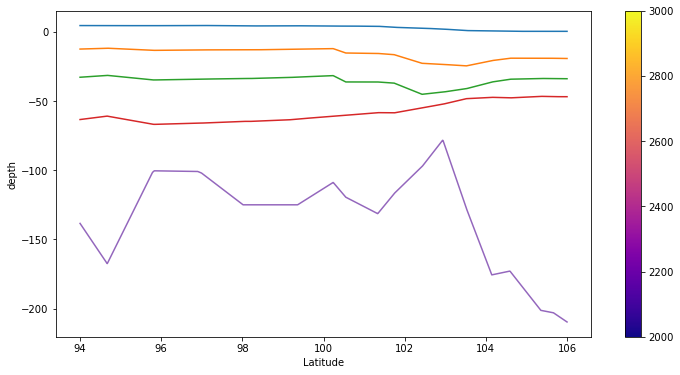

In [9]:
extent = [minlon,maxlon,-maxdepth,-mindepth]
# xticks = np.arange(20,45+5,5)
# yticks = np.arange(-250,10,25)

xcoords = lons
fig, ax = plt.subplots(1, 1, figsize=(12,6),facecolor="none")
ax.set(xlabel='Latitude', ylabel='depth') #,xticks=xticks,yticks=yticks_depth) #,title=fname_fig)
ax.plot(xcoords,topo)
ax.plot(xcoords,upperc_bot)
ax.plot(xcoords,midc_bot)
ax.plot(xcoords,moho)
ax.plot(xcoords,lab)
fig.colorbar(mappable=m1, ax=ax)

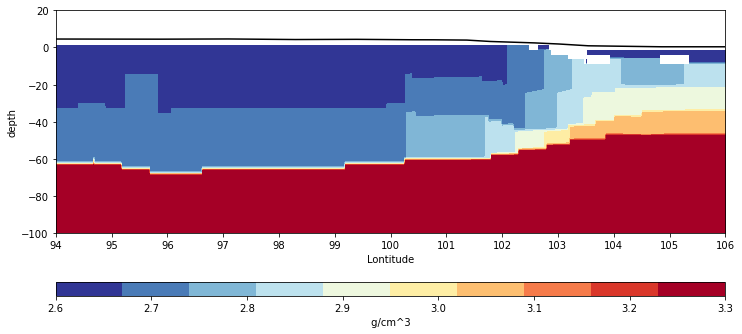

In [27]:
fname_fig = "Vertical density sections"
extent = [minlon,maxlon,-maxdepth,-mindepth]
xticks = np.arange(94,106+1,1)
yticks = np.arange(-260,20+1,20)

# yticks_depth = np.arange(-100,10,20)
# extent1=[minlon,maxlon,-250,10]
# cmap = plt.cm.get_cmap('RdYlBu_r', 10)

fig, ax = plt.subplots(1, 1, figsize=(12,6),facecolor="none")
ax.set(xlabel='Lontitude', ylabel='depth',xticks=xticks,yticks=yticks) #,title=fname_fig)
image = d[:,:]
image[np.where(image<1000.)]=np.nan
m1 = ax.imshow(image.T/1000,extent=extent1,origin="upper", cmap=cmap, aspect=1/30., vmin=2.6, vmax=3.3)
ax.plot(xcoords,topo,"k")
fig.colorbar(mappable=m1, ax=ax,orientation='horizontal',fraction =0.1,aspect=50,label=" g/cm^3 ")
ax.set_ylim([-100,20])
plt.savefig((outputPath+fname_fig+'.png'),dpi=dpi,bbox_inches='tight')

In [29]:
d[0,:]

array([   nan,    nan,    nan, 2584. , 2584. , 2584. , 2584. , 2584. ,
       2584. , 2669.5, 2669.5, 2669.5, 2669.5, 2669.5, 2669.5, 2669.5,
       2669.5, 2736. , 2736. , 2736. , 2736. , 2736. , 2736. , 2736. ,
       2736. , 2736. , 2736. , 2736. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. , 3300. ,
       3300. , 3300. , 3300. , 3300. ])